# FLANN (Fast Library for Approximate Nearest Neighbors)
Match similar features between 2 sets of key points, extracted from 2 images.



In [1]:
import os
import sys
import cv2
import matplotlib.pyplot as plt

# Add src directory to path to import our custom modules
sys.path.append(os.path.abspath('src'))

# --- Configuration ---
# Define all the paths we will need
CWD = os.getcwd()
XML_PATH = os.path.join(CWD, 'dataset', 'annotations.xml')
IMAGES_DIR = os.path.join(CWD, 'dataset', 'images')
YOLO_DATASET_DIR = os.path.join(CWD, 'strawberry_dataset')
TEMPLATE_PATH = os.path.join(CWD, 'template', 'template.png')
BASELINE_OUT = os.path.join(CWD, 'output', 'baseline_result.png')
PRETRAINED_MODEL = 'yolo11s.pt'
FINETUNED_OUT_DIR = os.path.join(CWD, 'output', 'finetuned_preds')
PRETRAINED_OUT_DIR = os.path.join(CWD, 'output', 'pretrained_preds')

# Ensure output and template directories exist
os.makedirs('output', exist_ok=True)
os.makedirs('template', exist_ok=True)

# Create template from annotation XML if not already present
from src.baseline import create_template
print("Generating template from dataset...")
create_template(XML_PATH, IMAGES_DIR, TEMPLATE_PATH)
print(f"Template saved to: {TEMPLATE_PATH}")

2025-07-03 18:55:43,987 - INFO - Template saved to c:\Users\wbrya\OneDrive\Documents\GitHub\ripe-strawberry-detector\template\template.png


Generating template from dataset...
Template saved to: c:\Users\wbrya\OneDrive\Documents\GitHub\ripe-strawberry-detector\template\template.png


In [2]:
from baseline import create_template
print("Generating template from dataset...")
create_template(XML_PATH, IMAGES_DIR, TEMPLATE_PATH)
print(f"Template saved to {TEMPLATE_PATH}")

2025-07-03 18:55:44,013 - INFO - Template saved to c:\Users\wbrya\OneDrive\Documents\GitHub\ripe-strawberry-detector\template\template.png


Generating template from dataset...
Template saved to c:\Users\wbrya\OneDrive\Documents\GitHub\ripe-strawberry-detector\template\template.png


In [3]:
import numpy as np
from sklearn.cluster import DBSCAN

# Create SIFT detector and FLANN matcher
sift = cv2.SIFT_create()
index_params = dict(algorithm=1, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

def run_flann(img_path, template_path, out_path):
    img = cv2.imread(img_path)
    template = cv2.imread(template_path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)

    kp1, des1 = sift.detectAndCompute(template_gray, None)
    kp2, des2 = sift.detectAndCompute(img_gray, None)
    if des1 is None or des2 is None:
        print("No descriptors found")
        return 0

    matches = flann.knnMatch(des1, des2, k=2)
    good = [m for m, n in matches if m.distance < 0.7 * n.distance]
    pts = np.array([kp2[m.trainIdx].pt for m in good])

    if len(pts) == 0:
        cv2.imwrite(out_path, img)
        return 0

    # Cluster matched points to find individual strawberries
    clustering = DBSCAN(eps=30, min_samples=1).fit(pts)
    labels = clustering.labels_
    # Count clusters excluding noise label -1
    count = len(set(labels)) - (1 if -1 in labels else 0)

    # Draw bounding boxes around each detected cluster
    for lbl in set(labels):
        if lbl == -1:
            continue
        cluster_pts = pts[labels == lbl].astype(int)
        x, y, w, h = cv2.boundingRect(cluster_pts)
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 3)

    cv2.imwrite(out_path, img)
    return count

Running FLANN matching on c:\Users\wbrya\OneDrive\Documents\GitHub\ripe-strawberry-detector\dataset\images\0.png...
FLANN detected 1 strawberries.


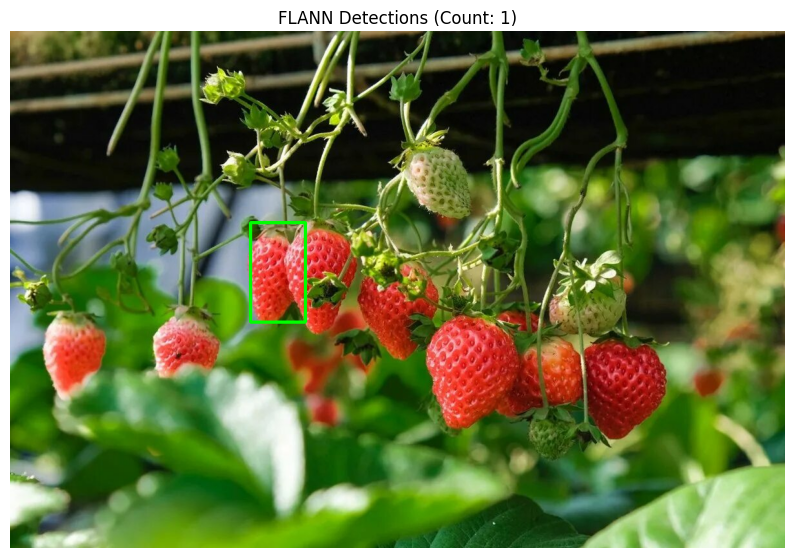

In [4]:
# Run FLANN matching on sample image 0
FLANN_OUT = os.path.join(CWD, 'output', 'flann_result0.png')
sample_image_path = os.path.join(IMAGES_DIR, '0.png')
print(f"Running FLANN matching on {sample_image_path}...")
flann_count = run_flann(sample_image_path, TEMPLATE_PATH, FLANN_OUT)
print(f"FLANN detected {flann_count} strawberries.")

# Display the result
flann_result = cv2.imread(FLANN_OUT)
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(flann_result, cv2.COLOR_BGR2RGB))
plt.title(f"FLANN Detections (Count: {flann_count})")
plt.axis('off')
plt.show()

Running FLANN matching on c:\Users\wbrya\OneDrive\Documents\GitHub\ripe-strawberry-detector\dataset\images\21.png...
FLANN detected 0 strawberries.


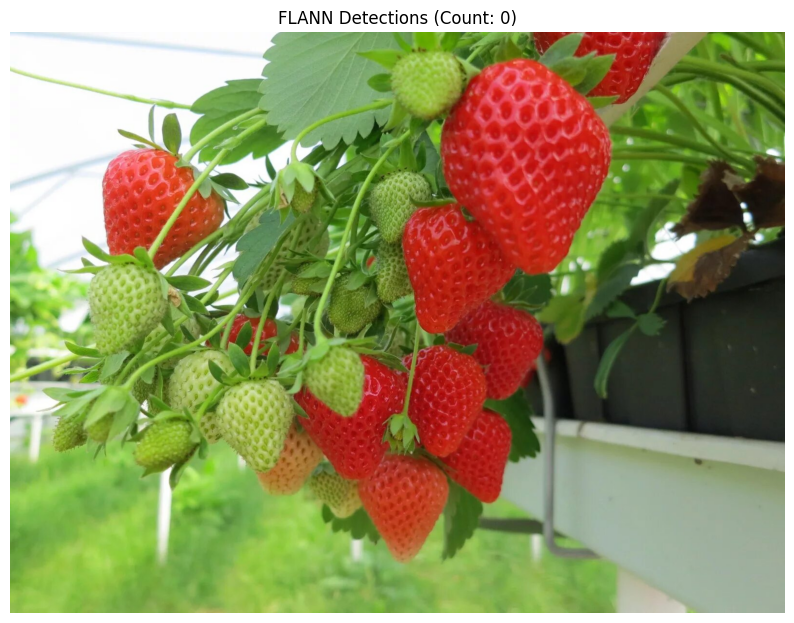

In [5]:
# Run FLANN matching on sample image 1
FLANN_OUT = os.path.join(CWD, 'output', 'flann_result1.png')
sample_image_path = os.path.join(IMAGES_DIR, '21.png')
print(f"Running FLANN matching on {sample_image_path}...")
flann_count = run_flann(sample_image_path, TEMPLATE_PATH, FLANN_OUT)
print(f"FLANN detected {flann_count} strawberries.")

# Display the result
flann_result = cv2.imread(FLANN_OUT)
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(flann_result, cv2.COLOR_BGR2RGB))
plt.title(f"FLANN Detections (Count: {flann_count})")
plt.axis('off')
plt.show()